In [ ]:
!pip3 install pandas seaborn matplotlib

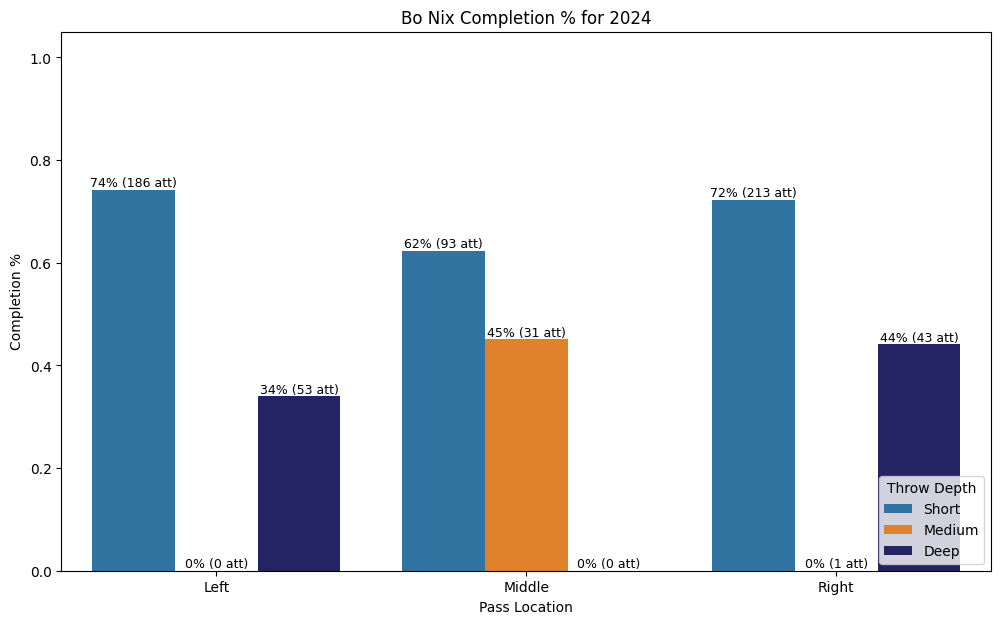

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

df = pd.read_csv("pbp_2024.csv")

if 'Gameid' in df.columns:
    df = df.drop_duplicates(subset='Gameid')
else:
    df = df.drop_duplicates()

#Clean Description column (remove hidden characters)
df['Description'] = df['Description'].str.replace(r'\xa0', ' ', regex=True)

#Filter Bo Nix passing plays
bo_nix_plays = df[df['Description'].str.contains("B.NIX", case=False)]
bo_nix_plays = bo_nix_plays[bo_nix_plays['PlayType'].str.contains("PASS", case=False)]

#Throw depth classification
def classify_throw(description):
    description = description.upper()
    if "SHORT" in description or "SWING" in description or "SCREEN" in description or "QUICK" in description or "SLANT" in description:
        return "Short"
    elif "MEDIUM" in description or "MID" in description or "CROSS" in description or "DIG" in description or "OUT ROUTE" in description:
        return "Medium"
    elif "DEEP" in description or "BOMB" in description or "FADE" in description or "GO ROUTE" in description or "POST" in description or "CORNER" in description:
        return "Deep"
    else:
        return "Unknown"

bo_nix_plays['Throw Depth'] = bo_nix_plays['Description'].apply(classify_throw)

#Pass location classification (more robust)
def pass_location(description):
    description = description.upper()
    if "LEFT" in description:
        return "Left"
    elif "MIDDLE" in description or "CENTER" in description:
        return "Middle"
    elif "RIGHT" in description:
        return "Right"
    else:
        return "Unknown"

bo_nix_plays['Pass Location'] = bo_nix_plays['Description'].apply(pass_location)

#Strip spaces from classifications
bo_nix_plays['Throw Depth'] = bo_nix_plays['Throw Depth'].str.strip()
bo_nix_plays['Pass Location'] = bo_nix_plays['Pass Location'].str.strip()

#Determine completion
def completion(description):
    description = description.upper()
    if "INCOMPLETE" in description or "DROPS" in description or "INTERCEPTED" in description: 
        return 0
    elif "SHORT RIGHT TO" in description or "SHORT LEFT TO" in description or "SHORT MIDDLE TO" in description or "DEEP RIGHT TO" in description or "DEEP LEFT TO" in description or "DEEP MIDDLE TO" in description:
        return 1
    else:
        return None

bo_nix_plays['Complete Pass'] = bo_nix_plays['Description'].apply(completion)

#Group by depth + location and include all combinations
depths = ['Short', 'Medium', 'Deep']
locations = ['Left', 'Middle', 'Right']
all_combinations = pd.MultiIndex.from_tuples(list(itertools.product(depths, locations)),
                                             names=['Throw Depth', 'Pass Location'])

combo_summary = (
    bo_nix_plays
    .groupby(['Throw Depth', 'Pass Location'], dropna=False)
    .agg(completion_rate=('Complete Pass', 'mean'), attempts=('Complete Pass', 'count'))
    .reindex(all_combinations, fill_value=0)  # fill missing combos with 0
    .reset_index()
)

custom_colors = {
    'Short': '#1f77b4',   # blue
    'Medium': '#ff7f0e',  # orange
    'Deep': '#191970'     # white
}

#Plot completion % with attempts
plt.figure(figsize=(12,7))
ax = sns.barplot(
    data=combo_summary,
    x='Pass Location',
    y='completion_rate',
    hue='Throw Depth',
    palette=custom_colors
)

#Annotate number of attempts above each bar
for i, row in combo_summary.iterrows():
    p = ax.patches[i]
    height = p.get_height()
    ax.annotate(
        f"{height*100:.0f}% ({row['attempts']} att)", 
        (p.get_x() + p.get_width()/2., height),
        ha='center',
        va='bottom',
        fontsize=9
    )

#Legend
plt.legend(title='Throw Depth', loc='lower right')
plt.title("Bo Nix Completion % for 2024")
plt.ylabel("Completion %")
plt.xlabel("Pass Location")
plt.ylim(0,1.05)
plt.show()